# M5 Forecast: Dept by Dept and Step by Step

Currently, the best public kernels ([Python](https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50), [R](https://www.kaggle.com/kailex/m5-forecaster-v2)) reach results of about 0.5. 

These fantastic notebooks (don't forget to vote them up!) are limited by two factors:

1. RAM usage is critical and prevents playing with more features.

2. The step-by-step predictions for the submission are slow.

This notebook solves the two issues by using these tricks:

- Each of the seven departments (FOODS_1 etc.) are treated separately in a loop. This **reduces memory requirement by a large factor**.

- Each step-by-step prediction requires just one row per `item_id` to predict - no need to calculate computer intensive *rolling* features for many rows during each step. This **speeds up the predictions by large factor**.

**This code is for playing - it is not meant to be the perfect solution**. Especially the choice of LightGBM parameters can be optimized. 

It additionally reveals how hard/easy each department is to predict. "FOODS_3" is particularly hard. Furthermore, the variable importances differ substantially across `dept_id`.

In [1]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb

## Load data

In [2]:
path = "../input/m5-forecasting-accuracy"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

## Prepare calendar data

In [3]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_type_1", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_name_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    
    return df

calendar = prep_calendar(calendar)
calendar.head()

wm_yr_wk  wday  month  year  d  event_name_1  event_name_2  snap_CA  \
0     11101     1      1  2011  1             1             1        0   
1     11101     2      1  2011  2             1             1        0   
2     11101     3      1  2011  3             1             1        0   
3     11101     4      2  2011  4             1             1        1   
4     11101     5      2  2011  5             1             1        1   

   snap_TX  snap_WI  
0        0        0  
1        0        0  
2        0        0  
3        1        0  
4        0        1

## Helper functions

We need the following functions.

In [4]:
from sklearn.model_selection import train_test_split

LAGS = [7, 28]
WINDOWS = [7, 28, 56]
FIRST = 1914
LENGTH = 28

def demand_features(df):
    """ Derive features from sales data and remove rows with missing values """
    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def demand_features_eval(df):
    """ Same as demand_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
    return out.reset_index()

def prep_data(df, drop_d=1000, dept_id="FOODS_1"):
    """ Prepare model data sets """
    
    print(f"\nWorking on dept {dept_id}")
    # Filter on dept_id
    df = df[df.dept_id == dept_id]
    df = df.drop(["dept_id", "cat_id"], axis=1)
    
    # Kick out old dates
    df = df.drop(["d_" + str(i+1) for i in range(drop_d)], axis=1)

    # Reshape to long
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(FIRST + i) for i in range(2 * LENGTH)])
    df = df.melt(id_vars=["id", "item_id", "store_id", "state_id"], var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"),
                   demand=df.demand.astype("float32"))
    
    # Add demand features
    df = demand_features(df)
    
    # Remove rows with NAs
    df = df[df.d > (drop_d + max(LAGS) + max(WINDOWS))]
 
    # Join calendar & prices
    df = df.merge(calendar, how="left", on="d")
    df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
    df = df.drop(["wm_yr_wk"], axis=1)
    
    # Ordinal encoding of remaining categorical fields
    for v in ["item_id", "store_id", "state_id"]:
        df[v] = OrdinalEncoder(dtype="int").fit_transform(df[[v]]).astype("int16") + 1
    
    # Determine list of covariables
    x = list(set(df.columns) - {'id', 'd', 'demand'})
            
    # Split into test, valid, train
    test = df[df.d >= FIRST - max(LAGS) - max(WINDOWS)]
    df = df[df.d < FIRST]

    xtrain, xvalid, ytrain, yvalid = train_test_split(df[x], df["demand"], test_size=0.1, shuffle=True, random_state=54)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xvalid, label = yvalid)

    return train, valid, test, x

def fit_model(train, valid, dept):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'learning_rate': 0.2 - 0.13 * (dept in ["HOBBIES_1", "HOBBIES_2", "HOUSEHOLD_2"]),
        'lambda': 0.1,
        'num_leaves': 50,
        'colsample_bytree': 0.7
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 5000, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 200)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10), title=dept);
    
    return fit

def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv", first=False):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 # https://www.kaggle.com/kyakovlev/m5-dark-magic
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False, mode='w' if first else 'a', header=first)
    
    return True

## The loop

For each department id, we will now prepare the model data set (including reshaping of sales data and join of the other data sources) and fit boosted trees individually for this department id. The results are then written to a csv for submission.


Working on dept FOODS_1
Training until validation scores don't improve for 200 rounds
[200]	valid_0's rmse: 2.02435
[400]	valid_0's rmse: 2.00485
[600]	valid_0's rmse: 1.99194
[800]	valid_0's rmse: 1.98476
[1000]	valid_0's rmse: 1.97998
[1200]	valid_0's rmse: 1.97542
[1400]	valid_0's rmse: 1.97295
[1600]	valid_0's rmse: 1.97178
Early stopping, best iteration is:
[1526]	valid_0's rmse: 1.97169

Working on dept FOODS_2
Training until validation scores don't improve for 200 rounds
[200]	valid_0's rmse: 1.69263
[400]	valid_0's rmse: 1.67124
[600]	valid_0's rmse: 1.66082
[800]	valid_0's rmse: 1.65319
[1000]	valid_0's rmse: 1.64864
[1200]	valid_0's rmse: 1.64416
[1400]	valid_0's rmse: 1.64153
[1600]	valid_0's rmse: 1.63958
[1800]	valid_0's rmse: 1.63812
[2000]	valid_0's rmse: 1.63779
[2200]	valid_0's rmse: 1.63714
Early stopping, best iteration is:
[2041]	valid_0's rmse: 1.63693

Working on dept FOODS_3
Training until validation scores don't improve for 200 rounds
[200]	valid_0's rmse: 3.04

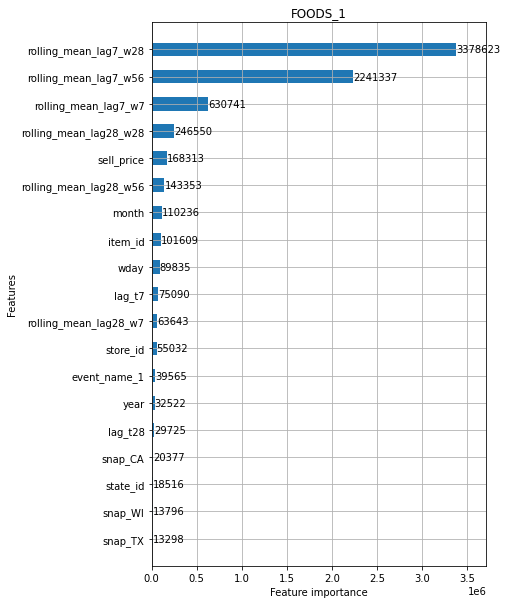

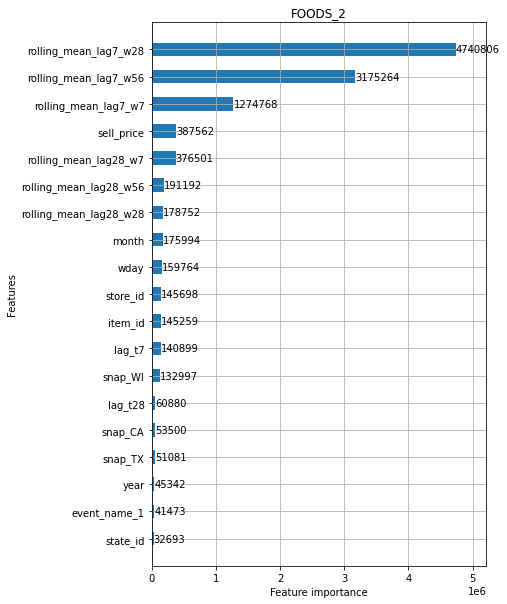

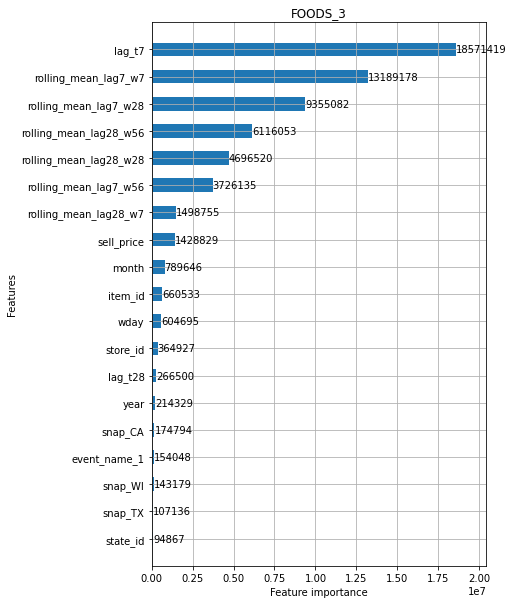

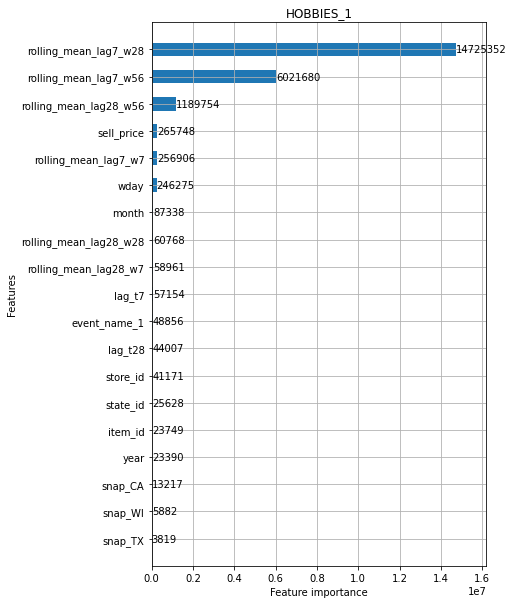

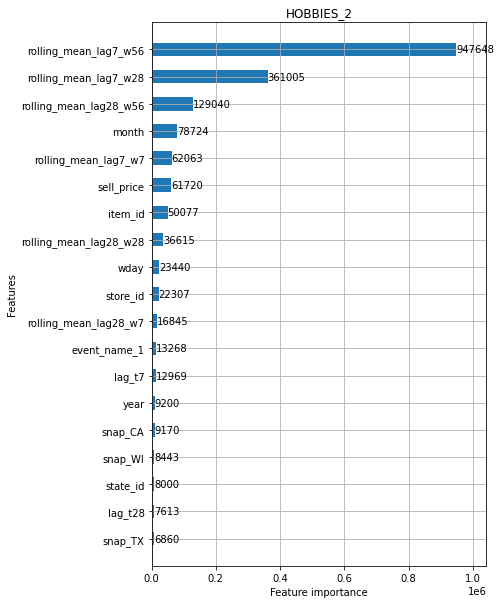

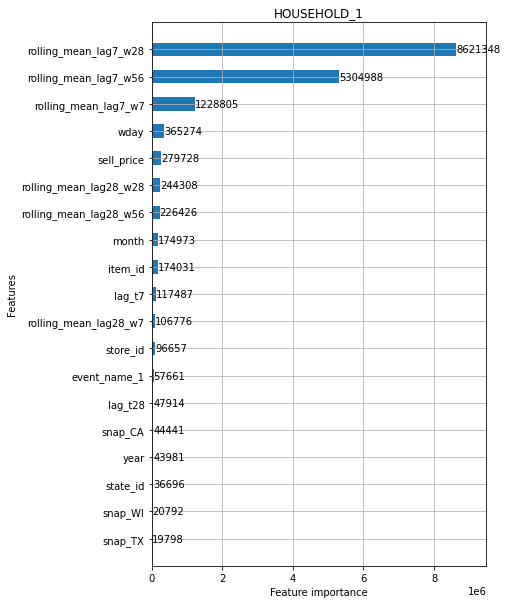

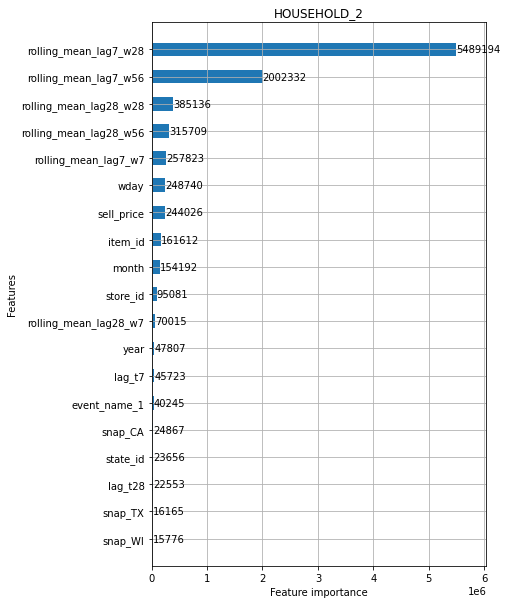

In [5]:
for i, dept in enumerate(np.unique(sales.dept_id)):
    train, valid, test, x = prep_data(sales, 1150, dept)
    fit = fit_model(train, valid, dept)
    pred_to_csv(fit, test, x, first=(i==0))